<h1 align="center"><font size="5">Loan Default Prediction</font></h1>

The last economic crisis in US was triggered by loan defaults. This example shows how important and critical to be able to predict the loan default. This helps banks or financial institutes to optimize their policies and to make better decisions when considering a loan application.

In this project we first investigate if loan status can be predicted by some identifying factors or not. Then we willattempt to identify the factors responsible for loan defaults. 
The product of this project a client classifier into two groups: 
1. Clients who who have paid off their loan.
2. Clinets who have not paid off their loan.


In this notebook we use four different classification algorithms to predict if a customer will pay off their loan on time or not. This is a binary classification problem.   
We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression
- Random Froests
- Neural Networks

The end-to-end pipeline used in this project composed of these steps: 
1. Download data
2. Exploratory data analysis
3. Data pre-processing
5. Predictive modeling based on training data:
    - Tune model parameter based on mode accuracy using k-fold cross-validation
    - Build final model
6. Use models to predict the target variable in new data
7. Report model accuracies and suggest the best classifier


#### Load data from a local Postgres server or directly from the web
The data is originally posted <a href="https://www.kaggle.com/zhijinzhai/loandata/activity">here </a>  on Kaggle. The financial product is a bullet loan that customers should pay off all of their loan debt in just one time by the end of the term, instead of an installment schedule. Of course, they could pay off earlier than their pay schedule. 
The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |



How to evaluate the model performance?  
Considering the business aspects, a bank or a credit card company might particularly wish to avoid incorrectly classifying an individual who will default, whereas incorrectly classifying an individual who who will not default, though still to be avoided, is less problematic.  This means minimizing the false negative.

#### Import libraries:

In [1]:
# import itertools # Functions creating iterators for efficient looping
import numpy as np # Support for large multi-dimensional matrices and high-level mathematical functions
import matplotlib.pyplot as plt # Visualization
# from matplotlib.ticker import NullFormatter
import pandas as pd # Data manipulations and analysis of numerical tables and time-series
# import matplotlib.ticker as ticker
import seaborn as sns
from sklearn import preprocessing #provides common utility functions to change raw feature vectors into a representation that is more suitable for the downstream estimators.
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
pd.options.mode.chained_assignment = None  #hide any pandas warnings
%matplotlib inline 
from sklearn.preprocessing import MinMaxScaler



## 1. Download data

In [2]:
!wget -O loan_train.csv https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_train.csv
print('Download compelete!')
df = pd.read_csv('loan_train.csv')
print(df.shape)
df.head(3)

--2019-04-17 16:46:54--  https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_train.csv
Resolving raw.githubusercontent.com... 151.101.200.133
Connecting to raw.githubusercontent.com|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23451 (23K) [text/plain]
Saving to: 'loan_train.csv'

loan_train.csv      100%[===================>]  22.90K  --.-KB/s    in 0.03s   

2019-04-17 16:46:55 (860 KB/s) - 'loan_train.csv' saved [23451/23451]

Download compelete!
(346, 10)


,user_id,Un_named,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male


### Exploratory visualization

In [3]:
def plot_adj(row, col, x_label, y_label, title):
    axis[row, col].set_axisbelow(True)
    axis[row, col].grid(which='minor', linestyle=':', color='black', alpha=0.2)
    axis[row, col].grid(which='major', linestyle='-', linewidth='0.5', color='red', alpha=0.2)
    axis[row, col].minorticks_on()
    axis[row, col].set_ylabel(y_label)
    axis[row, col].set_xlabel(x_label)
    axis[row, col].set_title(title, fontsize=16)

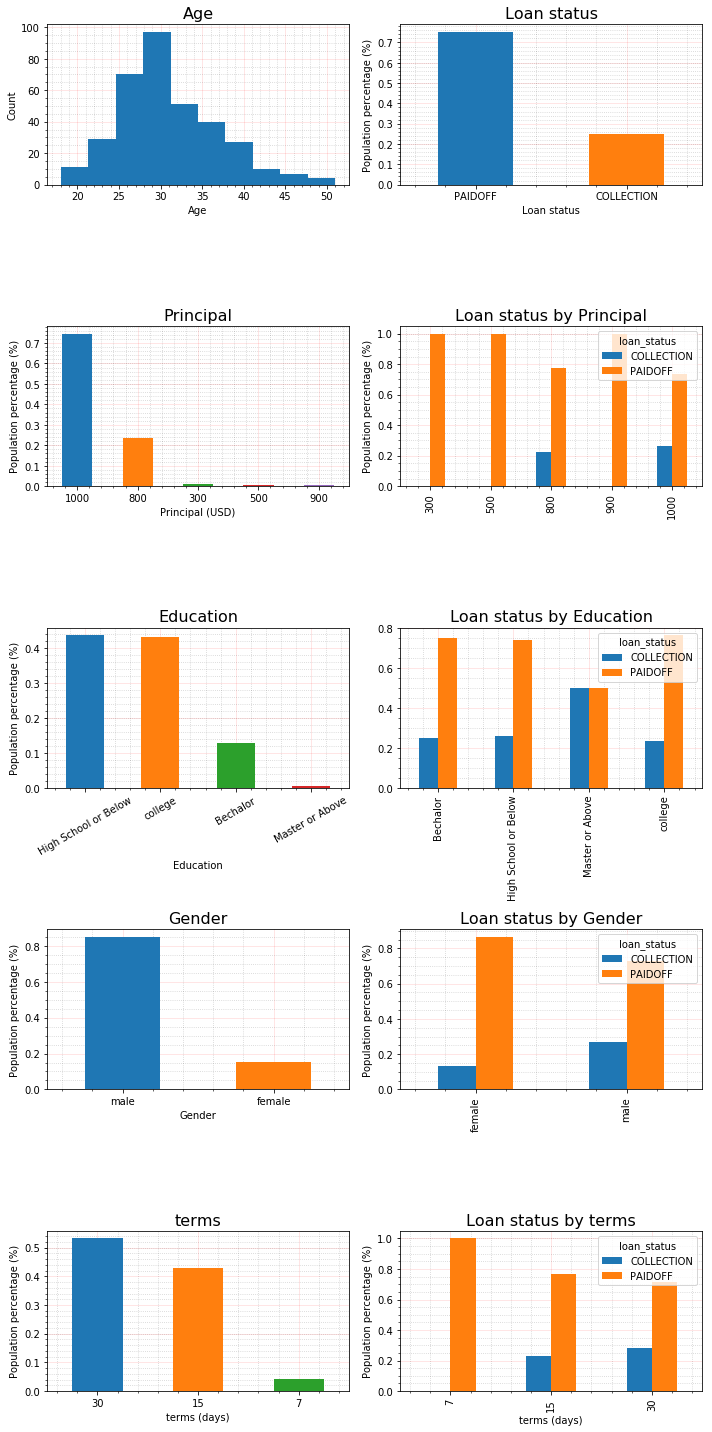

In [4]:
fig, axis = plt.subplots(5,2,figsize=(10,20), squeeze = 'False')
df['age'].plot(kind='hist', ax=axis[0, 0], rot='horizontal')
plot_adj(0, 0, 'Age', 'Count', 'Age')

(df['loan_status'].value_counts(normalize=True)
 .plot(kind='bar', ax=axis[0, 1], rot='horizontal'))
plot_adj(0, 1, 'Loan status', 'Population percentage (%)', 'Loan status')

(df['Principal'].value_counts(normalize=True).
 plot(kind='bar', ax=axis[1, 0], rot='horizontal'))
plot_adj(1, 0, 'Principal (USD)', 'Population percentage (%)','Principal')

(df.groupby(['Principal'])['loan_status'].value_counts(normalize=True).
 unstack().plot(kind='bar', ax=axis[1, 1], rot='vertical'))
plot_adj(1, 1, '', 'Population percentage (%)','Loan status by Principal')



(df['education'].value_counts(normalize=True).
 plot(kind='bar', ax=axis[2, 0], rot=30))
plot_adj(2, 0, 'Education', 'Population percentage (%)','Education')

(df.groupby(['education'])['loan_status'].value_counts(normalize=True).
 unstack().plot(kind='bar', ax=axis[2, 1], rot='vertical'))
plot_adj(2, 1, '', '','Loan status by Education')


(df['Gender'].value_counts(normalize=True).
 plot(kind='bar', ax=axis[3, 0], rot='horizontal'))
plot_adj(3, 0, 'Gender', 'Population percentage (%)','Gender')

(df.groupby(['Gender'])['loan_status'].value_counts(normalize=True).
 unstack().plot(kind='bar', ax=axis[3, 1], rot='vertical'))
plot_adj(3, 1, '', 'Population percentage (%)', 'Loan status by Gender')



(df['terms'].value_counts(normalize=True).
 plot(kind='bar', ax=axis[4, 0], rot='horizontal'))
plot_adj(4, 0, 'terms (days)', 'Population percentage (%)','terms')

(df.groupby(['terms'])['loan_status'].value_counts(normalize=True).
 unstack().plot(kind='bar', ax=axis[4, 1], rot='vertical'))
plot_adj(4, 1, 'terms (days)', 'Population percentage (%)','Loan status by terms')


fig.tight_layout() # to improve the spacing between subplots

The exploratory visualization of features show that there are very small amount of data points available for some levels of some features. For example only a very small fraction of costumers have applied for loan principal amounts of \$300, \$500, and \$900. The majority have applied for principal amounts of \$100 or \$800.  
We aslso see only a very small number of clients have Masters or above as their aducational level.  
The graphs also show how majority of clients have applied for loans with terms of either 30 or 15 days and aonly a very small fraction have applied for loans with a 7-day repayment period.  
Lets see the exact percentages of these less frequent data points:

In [5]:
print('Total number of data points (clients): {}\n'.format(df.shape[0]))
print('Number of cleints with loan terms of 7 months: {}'.format(df['terms'].value_counts(normalize=False)[7]))
print('Number of cleints with education level of masters or above: {} '.format(df['education'].value_counts(normalize=False)['Master or Above']))
print('Number of cleints with loan principal of $300: {}'.format(df['Principal'].value_counts(normalize=False)[300]))
print('Number of cleints with loan principal of $500: {}'.format(df['Principal'].value_counts(normalize=False)[500]))
print('Number of cleints with loan principal of $900: {}'.format(df['Principal'].value_counts(normalize=False)[900]))

Total number of data points (clients): 346

Number of cleints with loan terms of 7 months: 14
Number of cleints with education level of masters or above: 2 
Number of cleints with loan principal of $300: 3
Number of cleints with loan principal of $500: 2
Number of cleints with loan principal of $900: 2


Based on these observations I decided to drop the rows when the education level is Masters, or when the principal amount is one of these values: \$300, \$500, \$900.  
This happens in the next step along with some other preprocessing steps.

In [6]:
df['effective_date'].unique()

array(['9/8/2016', '9/9/2016', '9/10/2016', '9/11/2016', '9/12/2016',
       '9/13/2016', '9/14/2016'], dtype=object)

This shows how effective date contains only 7 distinct consecutive days, indicating that the whole dataset belong to a week period.

### How to categorize the "age" variable?

In [7]:
x = df.groupby(['age'])['loan_status'].value_counts(normalize=False).unstack()
#replaces Nan with 0:
x.fillna(0, inplace=True)
x['coll/total'] = x['COLLECTION']/(x['COLLECTION']+x['PAIDOFF'])
x.sort_values(by=['coll/total'], inplace=True)
x

loan_status,COLLECTION,PAIDOFF,coll/total
age,,,
51,0.0,1.0,0.000000
19,0.0,2.0,0.000000
20,0.0,3.0,0.000000
47,0.0,1.0,0.000000
43,0.0,3.0,0.000000
42,0.0,3.0,0.000000
36,1.0,8.0,0.111111
31,3.0,16.0,0.157895
33,3.0,14.0,0.176471


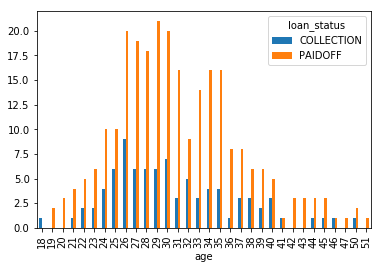

In [8]:
# Plot age versus loan status
(df.groupby(['age'])['loan_status'].value_counts(normalize=False).
 unstack().plot(kind='bar', rot='vertical'))
plt.show()

Based on this limited number of data points, there is no clear age pattern for default loans. 

## Data preparation and exploratory analysis

In [9]:
df.head()

,user_id,Un_named,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


#### Check for missing values

In [10]:
df.isnull().sum()

user_id           0
Un_named          0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

In [11]:
df.head()

,user_id,Un_named,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [12]:
# Dividing age in three Diffrent Group.
def Age(age):
    if 18<=age<32:
        return 0
    elif 32<=age<46:
        return 1
    else:
        return 2

In [13]:
def data_prepare(df):
    
    df = df[~(df.Principal.isin ([300, 500, 900]) | df.education.isin (['Master or Above']))]
    # Building a new feature based on the loan effective data:
    # The "effective_date" is object. Convert to "date time" type;
    df['effective_date'] = pd.to_datetime(df['effective_date'])
    df['eff_dayofweek'] = df['effective_date'].dt.dayofweek # Monday:0, Sunday:6
    # Now group days 0, 1, 2, 3 (week days) as "0"
    # and days 4,5,6 (Friday and weekends) as "1" together
    df['weekend'] = df['eff_dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
    # Droping unwanted Data from Dataframe
    df = df.drop(['user_id','Un_named', 'due_date', 'effective_date', 'eff_dayofweek'],
                 axis = 1)
    df = df.reset_index(drop=True) # reset the index to eliminate missing indices
    df = df.sample(frac=1).reset_index(drop=True) # shuffle the rows
    df['age'] = df['age'].apply(lambda x: Age(x))
    return df

In [14]:
print('Raw data:          rows={}, columns={}'.format(df.shape[0], df.shape[1]))
df = data_prepare(df)
print('Preprocessed data: rows={}, columns={}'.format(df.shape[0], df.shape[1]))
df.head()

Raw data:          rows=346, columns=10
Preprocessed data: rows=337, columns=7


,loan_status,Principal,terms,age,education,Gender,weekend
0,PAIDOFF,1000,30,1,college,male,1
1,PAIDOFF,1000,15,1,Bechalor,female,0
2,COLLECTION,1000,15,0,Bechalor,male,1
3,COLLECTION,800,15,2,High School or Below,male,1
4,PAIDOFF,1000,15,0,college,male,1


### Encoding categorical data

In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

labelencoder_edu = LabelEncoder()
df['Principal'] = labelencoder_edu.fit_transform(df['Principal'])
df['Gender'] = labelencoder_edu.fit_transform(df['Gender'])
# df['loan_status'] = labelencoder_edu.fit_transform(df['loan_status'])
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
df = pd.get_dummies(df, columns=["education"], prefix=["Edu"],
                    drop_first=True)
df = pd.get_dummies(df, columns=["terms"], prefix=["terms"],
                   drop_first=True)
# df = pd.get_dummies(df, columns=["eff_dayofweek"], prefix=["day_"])

In [17]:
df.head()

,loan_status,Principal,age,Gender,weekend,Edu_High School or Below,Edu_college,terms_15,terms_30
0,0,1,1,1,1,0,1,0,1
1,0,1,1,0,0,0,0,1,0
2,1,1,0,1,1,0,0,1,0
3,1,0,2,1,1,1,0,1,0
4,0,1,0,1,1,0,1,1,0


### Check pairwise correlations between features

In [18]:
def rand_jitter(arr):
    stdev = .04*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, 
           vmin=None, vmax=None, alpha=None, linewidths=None, 
           verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c,
                       marker=marker, cmap=cmap, norm=norm, vmin=vmin,
                       vmax=vmax, alpha=alpha, linewidths=linewidths,
                       verts=verts, hold=hold, **kwargs)

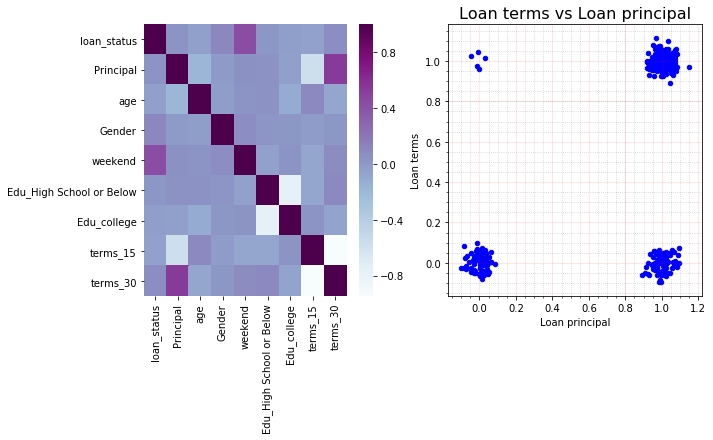

In [19]:
# Plotting heatmap of Data correlation
fig, axis = plt.subplots(1,2, squeeze = 'False', figsize = [10, 5])
sns.heatmap(data=df.corr(), cmap="BuPu", ax = axis[0])


jitter(x = df['Principal'], y = df['terms_30'])
# plt.axisbelow(True)
axis[1].grid(which='minor', linestyle=':', color='black', alpha=0.2)
axis[1].grid(which='major', linestyle='-', linewidth='0.5', color='red',
             alpha=0.2)
axis[1].minorticks_on()
axis[1].set_ylabel('Loan terms')
axis[1].set_xlabel('Loan principal')
axis[1].set_title('Loan terms vs Loan principal', fontsize=16)

plt.show()

- "term_15" and "term_30" are anti correlated.
- "term_15" and "Principal" are anti correlated.
- "term_30" and "Principal" are correlated.
- "weekend" and "loan_status" are correlated.

## Create Feature and Target dataset

In [20]:
X = df.drop(['loan_status' ], axis =1)
y = df['loan_status']

Function to plot model accuracy based on k-fold cross-validation:

In [21]:
def model_eval_plt(par, acu1,acu1_std,
                   acu2, acu2_std,
                   acu3, acu3_std,
                   model_name, model_par_name):
    # plot model accuracy for different values of k (k: number of neighbors)
    plt.figure(figsize=(10,5))
    plt.plot(par, acu1, linewidth = 2, label = 'F1 label 1')
    plt.fill_between(par, acu1-2*acu1_std, acu1+2*acu1_std,
                      label = 'F1 label 1 (+/-2std)', alpha = 0.2)
    
    plt.hold(True)
    plt.plot(par, acu2, linewidth = 2, label = 'F1 label 0')
    plt.fill_between(par, acu2-2*acu2_std, acu2+2*acu2_std,
                      label = 'F1 label 0 (+/-2std)', alpha = 0.2)
    
    plt.plot(par, acu3, linewidth = 2, label = 'MCC')
    plt.fill_between(par, acu3-2*acu3_std, acu3+2*acu3_std,
                      label = 'MCC (+/-2std)', alpha = 0.2)
    
    plt.legend()
    plt.ylabel('Accuracy', fontsize = 20)
    plt.xlabel('{}'.format(model_par_name),  fontsize = 20)
    plt.title('{} evaluation'.format(model_name), fontsize = 25)
    plt.yticks( fontsize = 15)
    plt.grid()
    plt.show()
    print('The highest F1 score (label 1) is {:3.3} for {}= {}\n'.format(max(acu1), model_par_name,
                                                                             par[np.argmax(acu1)]))
    print('The highest F1 score (label 0) is {:3.3} for {}= {}'.format(max(acu2), model_par_name,
                                                                             par[np.argmax(acu2)]))
        
    print('The highest MCC score is {:3.3} for {}= {}'.format(max(acu3), model_par_name,
                                                                             par[np.argmax(acu3)]))
        

## K-Nearest Neighbor classifier (KNN)



**Parameter tuning**:  
The number of neighbors (K) in KNN should be selected by the user. We use cross-validation to decide on the best K value according to model's performance accuracy. 

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, jaccard_similarity_score
from sklearn.metrics import f1_score, matthews_corrcoef, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [25]:
# Function that returns f1 score to be used in "cross_val_score"
def myF1_scorer(y_true, y_pred, **kwargs):
    return(f1_score(y_true, y_pred, pos_label = 0))

In [26]:
# Function that returns matthew's correlation coefficient to be used in "cross_val_score"
def myMCC_scorer(y_true, y_pred, **kwargs):
    return(matthews_corrcoef(y_true, y_pred))

In [27]:
# # under development ...
# def my_roc_auc_scorer(y_true, y_pred, **kwargs):
#     return(roc_auc_score(y_true, y_pred))

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_y

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_y

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encoun

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/an

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_y

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_y

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due 

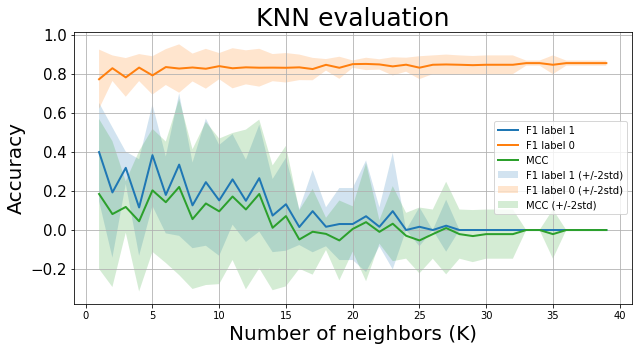

The highest F1 score (label 1) is 0.4 for Number of neighbors (K)= 1

The highest F1 score (label 0) is 0.856 for Number of neighbors (K)= 33
The highest MCC score is 0.221 for Number of neighbors (K)= 7


In [60]:
Ks = 40 # number of neighbors for KNN method

f1_0_vals = np.zeros((Ks-1))
f1_0_std_vals = np.zeros((Ks-1))

f1_1_vals = np.zeros((Ks-1))
f1_1_std_vals = np.zeros((Ks-1))

MCC_vals = np.zeros((Ks-1))
MCC_std_vals = np.zeros((Ks-1))

my_scorer_F1 = make_scorer(myF1_scorer)
my_scorer_MCC = make_scorer(myMCC_scorer)
# my_scorer_roc_auc = make_scorer(my_roc_auc_scorer)

for n in range(1, Ks):
    # Build the model
    knn = KNeighborsClassifier(n_neighbors=n)
      
    scores = cross_val_score(knn, X, y, cv = 10, scoring = 'f1')
    f1_0_vals[n-1] = scores.mean()
    f1_0_std_vals[n-1] = scores.std()

    scores = cross_val_score(knn, X, y, cv = 10, scoring = my_scorer_F1)
    f1_1_vals[n-1] = scores.mean()
    f1_1_std_vals[n-1] = scores.std()
        
    scores = cross_val_score(knn, X, y, cv = 10, scoring = my_scorer_MCC)
    MCC_vals[n-1] = scores.mean()
    MCC_std_vals[n-1] = scores.std()
    
#     scores = cross_val_score(knn, X, y, cv = 5, scoring = my_scorer_roc_auc)
#     MCC_vals[n-1] = scores.mean()
#     MCC_std_vals[n-1] = scores.std()
    
    
    
    
# plot model evaluation and find the optimum parameter
model_par_name = 'Number of neighbors (K)'
model_name = 'KNN'
model_eval_plt(list(range(1, Ks)), f1_0_vals,f1_0_std_vals,
               f1_1_vals,f1_1_std_vals,
               MCC_vals, MCC_std_vals,
               model_name, model_par_name)

**Build the final KNN model**  
Use the K-value that maximizes the model accuracy based on evaluation graph to build the final KNN model

In [61]:
k=7
knn = KNeighborsClassifier(n_neighbors=k)
# knn.fit(X_train, y_train) 
knn.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

As one can see, in addition to 'n_neighbors' there are other parameters that can be tuned in an attempt to achive higher accuracy, but we postpone is for now.

## Support Vector Machine (SVM):

**Parameter tuning**:

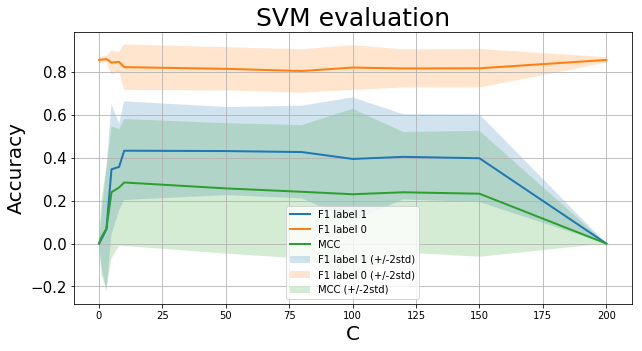

The highest F1 score (label 1) is 0.433 for C= 10.0

The highest F1 score (label 0) is 0.86 for C= 3.0
The highest MCC score is 0.285 for C= 10.0


In [72]:
from sklearn import svm

# kernels = ['linear', 'poly', 'rbf', 'sigmoid']
Cvals = np.array([0.1, 1,3, 5,8, 10,50,80, 100, 120, 150,200]) # Penalty parameter C of the error term.
n=0

f1_0_vals = np.zeros(len(Cvals))
f1_0_std_vals = np.zeros(len(Cvals))

f1_1_vals = np.zeros(len(Cvals))
f1_1_std_vals = np.zeros(len(Cvals))

MCC_vals = np.zeros(len(Cvals))
MCC_std_vals = np.zeros(len(Cvals))
                         
my_scorer_F1 = make_scorer(myF1_scorer)
my_scorer_MCC = make_scorer(myMCC_scorer)

for myC in Cvals:
    # Build the model
    loanSVM = svm.SVC(C = myC, kernel='sigmoid', gamma = 'auto')
    
    scores = cross_val_score(loanSVM, X, y, cv = 10, scoring = 'f1')
    f1_0_vals[n-1] = scores.mean()
    f1_0_std_vals[n-1] = scores.std()

    scores = cross_val_score(loanSVM, X, y, cv = 10, scoring = my_scorer_F1)
    f1_1_vals[n-1] = scores.mean()
    f1_1_std_vals[n-1] = scores.std()
        
    scores = cross_val_score(loanSVM, X, y, cv = 10, scoring = my_scorer_MCC)
    MCC_vals[n-1] = scores.mean()
    MCC_std_vals[n-1] = scores.std()

    n+=1

# plot model evaluation and find the optimum parameter
model_par_name = 'C'
model_name = 'SVM'
model_eval_plt(list(Cvals), f1_0_vals,f1_0_std_vals,
               f1_1_vals,f1_1_std_vals,
               MCC_vals, MCC_std_vals,
               model_name, model_par_name)

There are other parameters that can be tuned e.g. the degree of the polynomial function. This is beyond the scope of this work. 
The figure shows both polynomial (default degree of 3) and rbf result in same accuracy.

**Build final SVM classifier**:

In [73]:
loanSVM = svm.SVC(C = 10, kernel='sigmoid', gamma = 'auto')
loanSVM.fit(X, y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Logistic Regression

**Parameter tuning**

In [33]:
# import scikitplot as skplt
from sklearn import metrics
from sklearn.model_selection import cross_validate

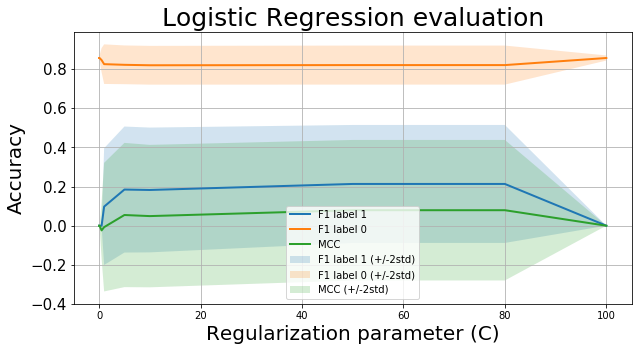

The highest F1 score (label 1) is 0.213 for Regularization parameter (C)= 50

The highest F1 score (label 0) is 0.856 for Regularization parameter (C)= 0.001
The highest MCC score is 0.0791 for Regularization parameter (C)= 50


In [85]:
from sklearn.linear_model import LogisticRegression
Cvec = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 80, 100]
n=0

f1_0_vals = np.zeros(len(Cvec))
f1_0_std_vals = np.zeros(len(Cvec))

f1_1_vals = np.zeros(len(Cvec))
f1_1_std_vals = np.zeros(len(Cvec))

MCC_vals = np.zeros(len(Cvec))
MCC_std_vals = np.zeros(len(Cvec))
                         
my_scorer_F1 = make_scorer(myF1_scorer)
my_scorer_MCC = make_scorer(myMCC_scorer)
for myC in Cvec:
    # Build the model
    LR = LogisticRegression(C=myC, solver='liblinear', penalty='l1') # liblinear is recommended for smal datasets
    
    scores = cross_val_score(LR, X, y, cv = 10, scoring = 'f1')
    f1_0_vals[n-1] = scores.mean()
    f1_0_std_vals[n-1] = scores.std()

    scores = cross_val_score(LR, X, y, cv = 10, scoring = my_scorer_F1)
    f1_1_vals[n-1] = scores.mean()
    f1_1_std_vals[n-1] = scores.std()
        
    scores = cross_val_score(LR, X, y, cv = 10, scoring = my_scorer_MCC)
    MCC_vals[n-1] = scores.mean()
    MCC_std_vals[n-1] = scores.std()

    n+=1    
# plot model evaluation and find the optimum parameter
model_par_name = 'Regularization parameter (C)'
model_name = 'Logistic Regression'
model_eval_plt(Cvec, f1_0_vals,f1_0_std_vals,
               f1_1_vals,f1_1_std_vals,
               MCC_vals, MCC_std_vals,
               model_name, model_par_name)

**Build final Logistic Regression classifier**:

In [86]:
LR = LogisticRegression(C=50, solver='liblinear', penalty='l1')
# LR.fit(X_train,y_train)
LR.fit(X,y)

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

## Random Forest classifier
Random forest model is a type of ensemble learning where a machine learning algorithm leverages many different other machine larning algorithms. Random forest method combines a lot of decision tree methods. 
Basically you first select the number of trees, then build each one of those decision trees based on a randomly selected subset of data. At the end when you have a new data point to predict, use each decision tree to predict the outcome for that new data point. The final result will be the category that received the highest vote from all trees.
Some extra notes about random forest from [here:](https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training/introducing-random-forest)  



Random forest belong to **ensemble learning** which is very popular in machine learning. Random forest is an ensemble learning method that constructs a collection of decision trees and then aggregates the predictions of each tree to determine the final prediction. So in this case, your weak models are the individual decision trees, and then those are combined into the strong model that is the aggregated random forest model. Benefits of random forest models: 
-  It's a very versatile and powerful machine learning algorithm. 
- It can be used for classification or regression, so that means a categorical response or a continuous response. 
- It easily handles outliers, missing values, skewed data, the data doesn't even have to be on the same scale. 
- It accepts various types of inputs as well, may it be ordinal or continuous data. 
- It's also less likely to overfit than some of the other machine learning models. 
- Outputs feature importance score

So random forest is really versatile and often cn=an make a terrefic first pass at your data, because you rarely have to do a lot of data cleaning, because it can accept pretty much anything. Beyond that it outputs the feature score, giving you the information which of the features are really usefull, and which aren't.  

**Hyper-parameter tuning:**

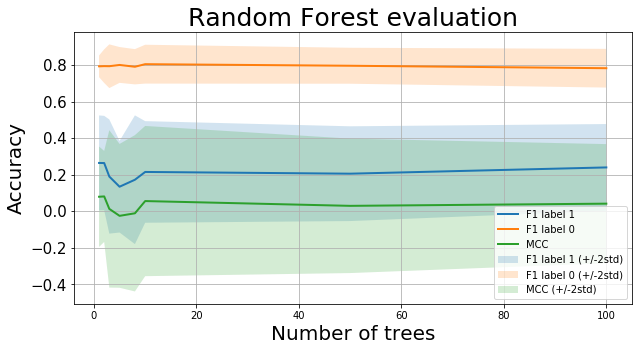

The highest F1 score (label 1) is 0.264 for Number of trees= 1

The highest F1 score (label 0) is 0.804 for Number of trees= 10
The highest MCC score is 0.0809 for Number of trees= 2


In [92]:
from sklearn.ensemble import RandomForestClassifier
# RF = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')
# RF.fit(X, y)

n_estimators_vec = np.array([1,2, 3, 5,8,10, 50, 100])
n=0

f1_0_vals = np.zeros(len(n_estimators_vec))
f1_0_std_vals = np.zeros(len(n_estimators_vec))

f1_1_vals = np.zeros(len(n_estimators_vec))
f1_1_std_vals = np.zeros(len(n_estimators_vec))

MCC_vals = np.zeros(len(n_estimators_vec))
MCC_std_vals = np.zeros(len(n_estimators_vec))
                         
my_scorer_F1 = make_scorer(myF1_scorer)
my_scorer_MCC = make_scorer(myMCC_scorer)
for my_n_estimators in n_estimators_vec:
    # Build the model
    RF = RandomForestClassifier(n_estimators = my_n_estimators,
                                criterion = 'entropy', 
                               random_state = 1) 
    scores = cross_val_score(RF, X, y, cv = 10, scoring = 'f1')
    f1_0_vals[n-1] = scores.mean()
    f1_0_std_vals[n-1] = scores.std()

    scores = cross_val_score(RF, X, y, cv = 10, scoring = my_scorer_F1)
    f1_1_vals[n-1] = scores.mean()
    f1_1_std_vals[n-1] = scores.std()
        
    scores = cross_val_score(RF, X, y, cv = 10, scoring = my_scorer_MCC)
    MCC_vals[n-1] = scores.mean()
    MCC_std_vals[n-1] = scores.std()

    n+=1

    # plot model evaluation and find the optimum parameter
model_par_name = 'Number of trees'
model_name = 'Random Forest'
model_eval_plt(n_estimators_vec, f1_0_vals,f1_0_std_vals,
               f1_1_vals,f1_1_std_vals,
               MCC_vals, MCC_std_vals,
               model_name, model_par_name)

#### Build the final Random Forest model:

In [93]:
RF = RandomForestClassifier(n_estimators = 2,
                                criterion = 'entropy', 
                               random_state = 0) 
RF.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## Gradient Boosting Classifier

Gradient Boosting is an ensemble model that uses an iterative approach to combining weak learners to create a strong learner by focusing on mistakes of prior iterations [(ref)](https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training/introducing-gradient-boosting). Gradient boosting uses decision trees as well but they are increadibly basic, like a decision stump. And then it evaluates what it gets right and what it gets wrong on that first tree, and then with the net iterations it places a **heavier weight on those observations that it got wrong** and it does this over and over again, focusing on the examples that it does not quite understand yet, until it has minimized the error as much as possible. So this is an incredibly powerfull technique. 
How is Gradient Boosting is different than Random Forest?
<a href="https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training/introducing-gradient-boosting"><img src="https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/RandomForest_vs_GradientBoosting.png" width="600" align="center"></a>

Now the question is why do we use Gradient Boosting? Gradient boosting is typically more powerfull and better performing if tunned properly.
Gradient boosting also accepts various types of inputs just like Random Forest, making it very flexible. It can also be used for classification or regression, and it outputs feature importance.
The drawbacks: Takes longer to be trained because it can not be parallelized (versus Random Forest can be parallelized and each tree can be grown independent of the others, but the gradient boosting works iteratively and can not be parallellized), it is possible to over fit the data because it obsesses over those ones that it got wrong, and it can get lost pursuing those outliers that don't really represent the overall population. It is also harder to tune because there a re more parameters.

## Deep learning binary classifier

In [99]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import numpy

In [100]:
# fix random seed for reproducibility
np.random.seed(1234)

# model = Sequential()
# model.add(Dense(12, input_dim=8, init='uniform', activation='sigmoid'))
# model.add(Dense(12, init='uniform', activation='relu'))
# model.add(Dense(12, init='uniform', activation='relu'))
# model.add(Dense(12, init='uniform', activation='relu'))
# model.add(Dense(12, init='uniform', activation='relu'))
# model.add(Dense(12, init='uniform', activation='relu'))
# model.add(Dense(12, init='uniform', activation='relu'))
# model.add(Dense(1, init='uniform', activation='sigmoid'))

model = Sequential()
model.add(Dense(64, input_dim=8, init='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [101]:
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [102]:
# # convert target variable to a binary one

# df_copy = df
# df['loan_status_bin'] = df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'], value=[0,1])
# # df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)


In [103]:
# Feature = df[['Principal','terms','age','Gender','weekend']]
# Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
# X = Feature
# y = df['loan_status_bin'].values


In [104]:
model.fit(X, y, nb_epoch=150, batch_size=20)
scores = model.evaluate(X, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
337/337 [==============================] - 0s 991us/step - loss: 0.6923 - acc: 0.5252
Epoch 2/150
337/337 [==============================] - 0s 76us/step - loss: 0.6346 - acc: 0.7478
Epoch 3/150
337/337 [==============================] - 0s 73us/step - loss: 0.6103 - acc: 0.7478
Epoch 4/150
337/337 [==============================] - 0s 69us/step - loss: 0.5854 - acc: 0.7478
Epoch 5/150
337/337 [==============================] - 0s 73us/step - loss: 0.5689 - acc: 0.7478
Epoch 6/150
337/337 [==============================] - 0s 77us/step - loss: 0.5663 - acc: 0.7478
Epoch 7/150
337/337 [==============================] - 0s 72us/step - loss: 0.5519 - acc: 0.7478
Epoch 8/150
337/337 [==============================] - 0s 77us/step - loss: 0.5234 - acc: 0.7478
Epoch 9/150
337/337 [==============================] - 0s 68us/step - loss: 0.5260 - acc: 0.7478
Epoch 10/150
337/337 [==============================] - 0s 76us/step - loss: 0.5217 - acc: 0.7478
Epoch 11/150
337/337 [======

## 6. Use models to predict the target variable in new data

### 6.1 Preprocessing of new datset:

**Download** and **load** the new dataset:

In [46]:
# !wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
!wget -O loan_test.csv https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_test.csv
print('Download complete!')

--2019-04-17 16:51:31--  https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_test.csv
Resolving raw.githubusercontent.com... 151.101.200.133
Connecting to raw.githubusercontent.com|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/plain]
Saving to: 'loan_test.csv'

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2019-04-17 16:51:32 (18.5 MB/s) - 'loan_test.csv' saved [3642/3642]

Download complete!


In [47]:
test_df = pd.read_csv('loan_test.csv')
test_df.head(3)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female


In [48]:
test_df.shape

(54, 10)

**Preprocess** new dataset  
Preprocess in the SAME way as training data.

In [49]:
test_df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'due_date'], inplace=True, axis=1)

test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['eff_dayofweek'] = test_df['effective_date'].dt.dayofweek # Monday:0, Sunday:6


test_df['weekend'] = test_df['eff_dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df.drop(['effective_date', 'eff_dayofweek'], inplace=True, axis=1)
test_df = test_df[~(test_df.Principal.isin ([300, 500, 900]) | test_df.education.isin (['Master or Above']))]
test_df = test_df.reset_index(drop=True)


In [50]:
labelencoder_edu = LabelEncoder()
test_df['Principal'] = labelencoder_edu.fit_transform(test_df['Principal'])
test_df['Gender'] = labelencoder_edu.fit_transform(test_df['Gender'])
# test_df['loan_status'] = labelencoder_edu.fit_transform(test_df['loan_status'])
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)


test_df = pd.get_dummies(test_df, columns=["education"], 
                         prefix=["Edu"], drop_first = True)
test_df = pd.get_dummies(test_df, columns=["terms"], 
                         prefix=["terms"], drop_first = True)
test_df['age'] = test_df['age'].apply(lambda x: Age(x))

In [51]:
test_df.head()

,loan_status,Principal,age,Gender,weekend,Edu_High School or Below,Edu_college,terms_15,terms_30
0,0,2,2,0,0,0,0,0,1
1,0,2,1,0,1,1,0,0,1
2,0,2,0,1,1,0,1,0,1
3,0,1,0,1,1,0,0,1,0
4,0,0,1,1,1,1,0,1,0


Extract **features** and **target** data from new dataset:

In [52]:
X_new = test_df.drop(['loan_status'], axis =1)
y_new = test_df[['loan_status']]

### 6.2 Predictive modeling on new dataset

In [53]:
from sklearn import metrics

In [54]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [111]:
# KNN
# Notice that we are now using the model we have built previously
yhat = knn.predict(X_new)

(print('Accuracy MCC = {:3.3}'
       .format(matthews_corrcoef(y_new, yhat)
    )))
print (metrics.classification_report(y_new, yhat))
cf_KNN = confusion_matrix(y_new, yhat)
print(cf_KNN)
x = (perf_measure(y_new['loan_status'].values, yhat))
print('TP = {}, FP={}, TN={}, FN={}'.format(x[0], x[1], x[2], x[3]))

Accuracy MCC = 0.339
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        37
           1       0.62      0.36      0.45        14

   micro avg       0.76      0.76      0.76        51
   macro avg       0.71      0.64      0.65        51
weighted avg       0.75      0.76      0.74        51

[[34  3]
 [ 9  5]]
TP = 5, FP=3, TN=34, FN=9


In [112]:
y_comb = y_new.copy()
y_comb['pred'] = yhat
y_comb

,loan_status,pred
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


**Interpretation of results for KNN classifier:**  
The KNN classifier performed differently for ***good*** (loan status = payed off) versus ****bad*** (loan status=default) clients. More specifically KNN performed:
- Reasonably well in predicting the loan status for good clients: 78% of model predictions about the 'good' clinets were correct (precision). The model also predicted 84% of "good" clients (recall).  


- Poorly in predicting the 'bad' clients: 45% of model predictions about bad clients were actually correct (precision). Only 40% of "bad" clients were identified by the model (recall).  

-------
Now the main question is if the bank should use the predictions of this model to decide on accepting or rejecting a loan request for a new client?  

To answer this question we need to know the costs and benefits. Lets assume that the bank makes \$100 when a good clinet requests a loan. On the other hand the bank loose \$300 for a default loan. Lets use this information and compare the amount of money that bank will make (or loose) in four different scenarieos:
1. Bank uses KNN model predictions and accepts loan requests when model says a client is a good one (label 0, equevalent to TN and FN cases). Based on this the total money that bank will make on the new dataset will be: 
 
\begin{equation*}
100\sum TN - 300 \sum FN = 31\times100 - 9\times300 = 3100-2700 = + \$400
\end{equation*}
2. Bank accepts all loan applications. 

\begin{equation*}
100(\sum TN  + \sum FP) - 300(\sum TP  + \sum FN) = (31+6)\times100 - (5+9)\times300 = 3700-4200 = - \$500
\end{equation*}
3. Bank uses a naive (random) policy in decision making and accepts 50% of all applicants by chance:

\begin{equation*}
100\frac{(\sum TN  + \sum FP)}{2} - 300\frac{(\sum TP  + \sum FN)}{2} = \frac{(31+6)}{2}\times100 - \frac{(5+9)}{2}\times300 = 1850-2100 = - \$250
\end{equation*}
4. The best possible outcome: The bank accepts all good clinets and rejects all bad ones:

\begin{equation*}
100(\sum TN  + \sum FP) = (31+6)\times100 = + \$3700
\end{equation*}


This indicates how does the model work better than chance or other naive ways of decision making for the special cost-benefit values.

We can do this in a more systematic way and plot the amount of the mony bank makes versus different cost-benefit ratios defined as:

In [64]:
def cost_benefit_plot(cf):
    
    TN = cf[0, 0]
    FN= cf[1, 0]
    TP = cf[1, 1]
    FP = cf[0, 1]
    cost_benefit_ratio = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    cost_benefit_ratio = np.array(cost_benefit_ratio)
    gain = TN-(FN*cost_benefit_ratio)
    all_accepted = (TN + FP - ((TP+FN)*cost_benefit_ratio)) # baseline 1
    half_accepted = 0.5*(TN + FP - ((TP+FN)*cost_benefit_ratio))  # baseline 2
    best_outcome = (TN + FP)*np.ones(len(cost_benefit_ratio))

    plt.figure(figsize=(12,5))
    plt.plot(cost_benefit_ratio, all_accepted, label = 'all accepted', lw=3)
    plt.plot(cost_benefit_ratio, half_accepted, label = '50% accepted', lw=3)
    plt.plot(cost_benefit_ratio, best_outcome, label = 'best outcome', lw=3)
    plt.plot(cost_benefit_ratio, gain, label = 'model', lw=3)


    plt.legend(fontsize = 15)
    plt.ylabel('Total Gain or Loss for Bank', fontsize = 20)
    plt.xlabel('Gain-Loss ratio per client (G/L)',  fontsize = 20)
    plt.title('Using model vs naive methods in decision making by bank'.format(model_name), fontsize = 25)
    plt.yticks( fontsize = 15)
    plt.xticks( fontsize = 15)
    plt.grid()
    plt.grid(which='major', linestyle='-', linewidth='1', color='k', alpha=0.2)
    plt.show()

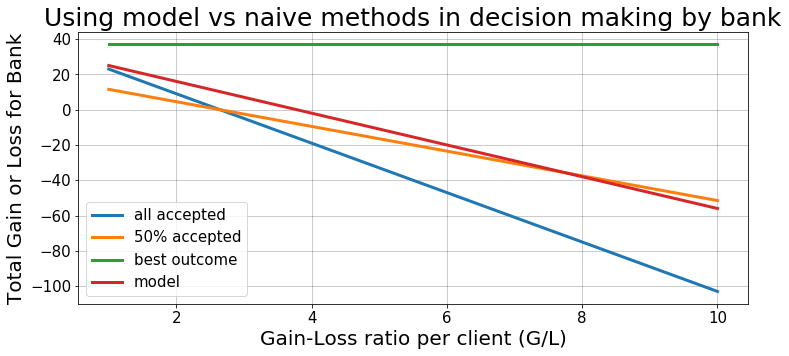

In [65]:
cost_benefit_plot(cf_KNN)

**Conclusion:**
Whether the bank should use the model predicitions or not to make decisions depends on the ration of how much money is lostfor a default loan and how much is gained for a paid-off loan (Gain-Loss ratio per client, G/L).  

- 1 < G/L < 3.8: The bank will gain capital if uses the model predictions 
- 3.8 < G/L < 6.8  : The bank will loss money, but less money will be lost if model predictions are used.
-       6.8  < G/L  : The bank will loose money, but less money will be lost if the 50% random acceptance is used instead of other methods.

In [ ]:
# !conda install -c anaconda eli5 -y

In [66]:
import eli5
from eli5.sklearn import PermutationImportance

In [67]:
perm = PermutationImportance(knn, random_state=1).fit(X_new, y_new)
eli5.show_weights(perm, feature_names = X_new.columns.tolist())

Weight,Feature
0.0510 ± 0.0400,Gender
0.0471 ± 0.0587,Edu_High School or Below
0.0235 ± 0.0457,terms_30
0.0157 ± 0.0520,age
0.0078 ± 0.0400,weekend
-0.0118 ± 0.0192,Principal
-0.0157 ± 0.0800,terms_15
-0.0275 ± 0.0192,Edu_college


In [68]:
# !conda install -c anaconda pdpbox -y
from pdpbox import pdp, info_plots #for partial plots

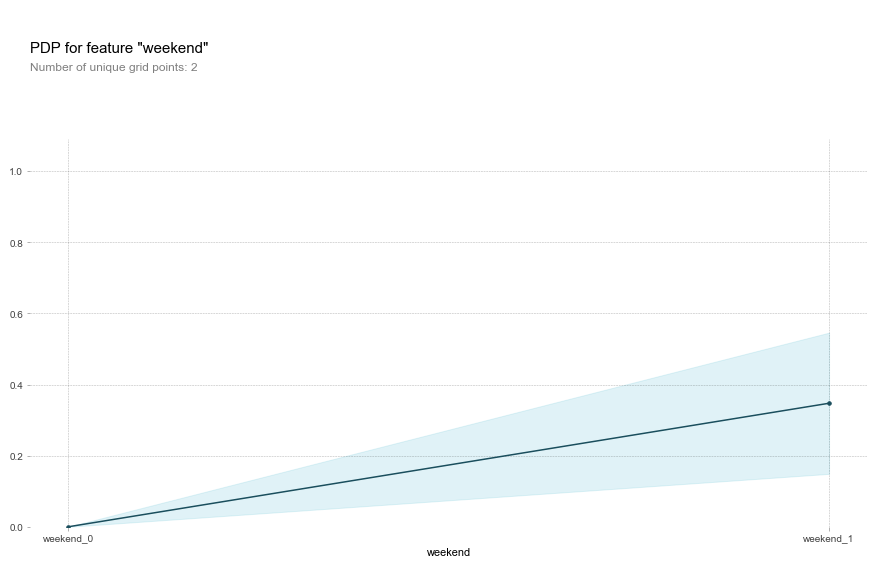

In [69]:
base_features = test_df.columns.values.tolist()
base_features.remove('loan_status')

feat_name = 'weekend'
pdp_dist = pdp.pdp_isolate(model=knn, dataset=X_new,
                           model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

In [74]:
# SVM
yhat = loanSVM.predict(X_new)
(print('Accuracy MCC = {:3.3}'
       .format(matthews_corrcoef(y_new, yhat)
    )))
print (metrics.classification_report(y_new, yhat))
cf_SVM = confusion_matrix(y_new, yhat)
print(cf_SVM)
x = (perf_measure(y_new['loan_status'].values, yhat))
print('TP = {}, FP={}, TN={}, FN={}'.format(x[0], x[1], x[2], x[3]))

Accuracy MCC = 0.23
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        37
           1       1.00      0.07      0.13        14

   micro avg       0.75      0.75      0.75        51
   macro avg       0.87      0.54      0.49        51
weighted avg       0.81      0.75      0.65        51

[[37  0]
 [13  1]]
TP = 1, FP=0, TN=37, FN=13


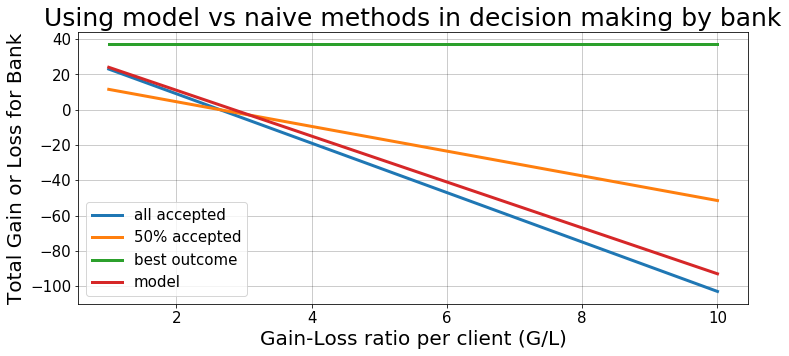

In [75]:
cost_benefit_plot(cf_SVM)

**Conclusion**: The SVM model works just slightly better than 'all accepted' scenario.

In [76]:
y_comb = y_new.copy()
y_comb['pred'] = yhat
y_comb

,loan_status,pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [79]:
# Logistic regression
yhat = LR.predict(X_new)
yhat_prob = LR.predict_proba(X_new) # for LogLoss score that works on the probability of model prediction
(print('Accuracy MCC = {:3.3}'
       .format(matthews_corrcoef(y_new, yhat)
    )))
print (metrics.classification_report(y_new, yhat))
cf_LR = confusion_matrix(y_new, yhat)
print(cf_LR)
x = (perf_measure(y_new['loan_status'].values, yhat))
print('TP = {}, FP={}, TN={}, FN={}'.format(x[0], x[1], x[2], x[3]))

Accuracy MCC = 0.0
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        37
           1       0.00      0.00      0.00        14

   micro avg       0.73      0.73      0.73        51
   macro avg       0.36      0.50      0.42        51
weighted avg       0.53      0.73      0.61        51

[[37  0]
 [14  0]]
TP = 0, FP=0, TN=37, FN=14


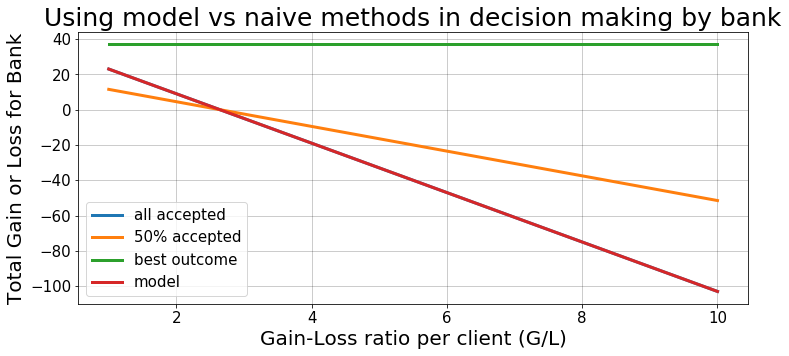

In [80]:
cost_benefit_plot(cf_LR)

**Conclusion**. 
The Logistic Regression model does not provide any informative predictions and works as 'all accepted' scenario. 

In [94]:
y_comb = y_new.copy()
y_comb['pred'] = yhat
y_comb

,loan_status,pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [95]:
# Random Forest
yhat = RF.predict(X_new)
(print('Accuracy MCC = {:3.3}'
       .format(matthews_corrcoef(y_new, yhat)
    )))
print (metrics.classification_report(y_new, yhat))
cf_RF = confusion_matrix(y_new, yhat)
print(cf_RF)
x = (perf_measure(y_new['loan_status'].values, yhat))
print('TP = {}, FP={}, TN={}, FN={}'.format(x[0], x[1], x[2], x[3]))

Accuracy MCC = 0.36
              precision    recall  f1-score   support

           0       0.80      0.89      0.85        37
           1       0.60      0.43      0.50        14

   micro avg       0.76      0.76      0.76        51
   macro avg       0.70      0.66      0.67        51
weighted avg       0.75      0.76      0.75        51

[[33  4]
 [ 8  6]]
TP = 6, FP=4, TN=33, FN=8


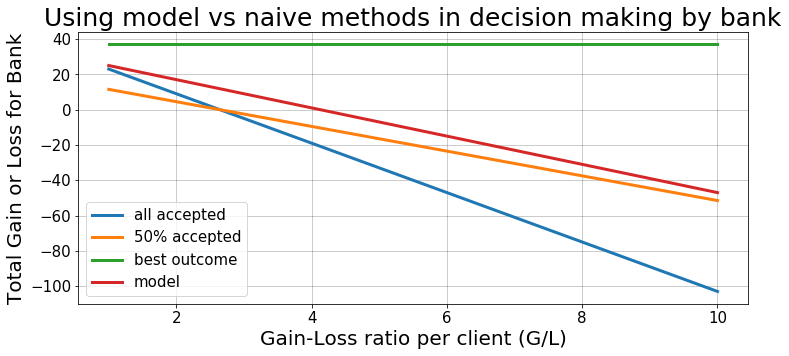

In [96]:
cost_benefit_plot(cf_RF)

**Conclusion:**
Whether the bank should use the Random Forest model predicitions or not to make decisions depends on Gain-Loss ratio per client (G/L).  

- 1   < G/L < 1.2: The bank will gain capital if uses the all-accepted policy
- 1.2 < G/L < 3.5: The bank will gain higher capital if uses the model predictions 
- 3.5 < G/L < 4.5  : The bank will loss money, but less money will be lost if the model predictions are used.
-       4.5  < G/L  : The bank will loose money, but less money will be lost if the 50% random acceptance is used instead of other methods.

In [97]:
perm = PermutationImportance(RF, random_state=1).fit(X_new, y_new)
eli5.show_weights(perm, feature_names = X_new.columns.tolist())

Weight,Feature
0.0745 ± 0.0457,Edu_High School or Below
0.0667 ± 0.0637,terms_30
0.0471 ± 0.0684,weekend
0.0314 ± 0.0684,age
0.0235 ± 0.0520,Gender
-0.0039 ± 0.0157,Principal
-0.0157 ± 0.0457,terms_15
-0.0275 ± 0.0471,Edu_college


In [98]:
y_comb = y_new.copy()
y_comb['pred'] = yhat
y_comb

,loan_status,pred
0,0,0
1,0,0
2,0,0
3,0,1
4,0,1
5,0,0
6,0,0
7,0,0
8,0,1
9,0,0


In [105]:
# DL
yhat = model.predict(X_new)
yhat_binary = yhat.copy()
yhat_binary[yhat > 0.1] = 1
yhat_binary[yhat <= 0.1] = 0


(print('Accuracy MCC = {:3.3}'
       .format(matthews_corrcoef(y_new, yhat_binary)
    )))
print (metrics.classification_report(y_new, yhat_binary))
cf_DL = confusion_matrix(y_new, yhat_binary)
print(cf_DL)
x = (perf_measure(y_new['loan_status'].values, yhat_binary))
print('TP = {}, FP={}, TN={}, FN={}'.format(x[0], x[1], x[2], x[3]))


Accuracy MCC = 0.44
              precision    recall  f1-score   support

           0       0.90      0.70      0.79        37
           1       0.50      0.79      0.61        14

   micro avg       0.73      0.73      0.73        51
   macro avg       0.70      0.74      0.70        51
weighted avg       0.79      0.73      0.74        51

[[26 11]
 [ 3 11]]
TP = 11, FP=11, TN=26, FN=3


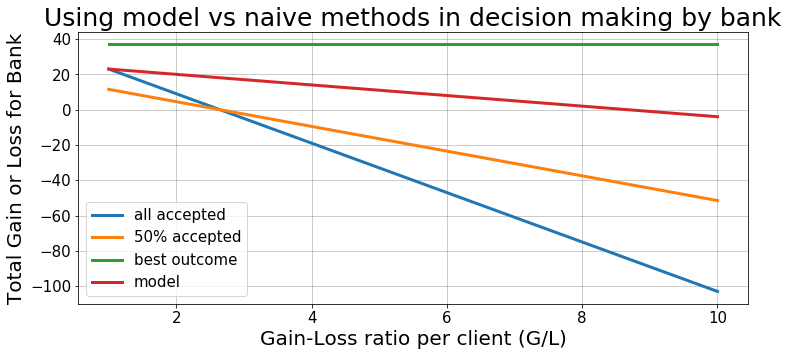

In [106]:
cost_benefit_plot(cf_DL)

In [107]:
y_comb = y_new.copy()
y_comb['pred_prob'] = yhat
y_comb['pred'] =  yhat_binary


y_comb

,loan_status,pred_prob,pred
0,0,8.740131e-07,0.0
1,0,1.984173e-02,0.0
2,0,3.896414e-01,1.0
3,0,5.013403e-01,1.0
4,0,5.275816e-01,1.0
5,0,3.479175e-01,1.0
6,0,8.495428e-02,0.0
7,0,4.443699e-01,1.0
8,0,3.168146e-01,1.0
9,0,3.300593e-01,1.0


In [108]:
def cf_elements(cf):
    TN = cf[0, 0]
    FN= cf[1, 0]
    TP = cf[1, 1]
    FP = cf[0, 1]
    return [TN, FN, TP, FP]

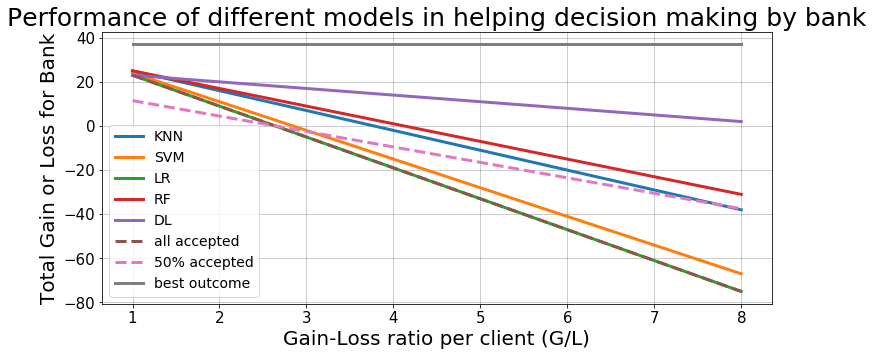

In [109]:
# def cost_benefit_plot(cf):
    
TN , FN, TP ,FP = cf_elements(cf_KNN)
cost_benefit_ratio = [1, 2, 3, 4, 5, 6, 7, 8]
cost_benefit_ratio = np.array(cost_benefit_ratio)
gain = TN-(FN*cost_benefit_ratio)
all_accepted = (TN + FP - ((TP+FN)*cost_benefit_ratio)) # baseline 1
half_accepted = 0.5*(TN + FP - ((TP+FN)*cost_benefit_ratio))  # baseline 2
best_outcome = (TN + FP)*np.ones(len(cost_benefit_ratio))
plt.figure(figsize=(12,5))
plt.plot(cost_benefit_ratio, gain, label = 'KNN', lw=3)


TN , FN, TP ,FP = cf_elements(cf_SVM)
gain = TN-(FN*cost_benefit_ratio)
plt.plot(cost_benefit_ratio, gain, label = 'SVM', lw=3)

TN , FN, TP ,FP = cf_elements(cf_LR)
gain = TN-(FN*cost_benefit_ratio)
plt.plot(cost_benefit_ratio, gain, label = 'LR', lw=3)

TN , FN, TP ,FP = cf_elements(cf_RF)
gain = TN-(FN*cost_benefit_ratio)
plt.plot(cost_benefit_ratio, gain, label = 'RF', lw=3)

TN , FN, TP ,FP = cf_elements(cf_DL)
gain = TN-(FN*cost_benefit_ratio)
plt.plot(cost_benefit_ratio, gain, label = 'DL', lw=3)

plt.plot(cost_benefit_ratio, all_accepted, label = 'all accepted', lw=3, linestyle='--')
plt.plot(cost_benefit_ratio, half_accepted, label = '50% accepted', lw=3,linestyle='--')
plt.plot(cost_benefit_ratio, best_outcome, label = 'best outcome', lw=3)



plt.legend(fontsize = 14)
plt.ylabel('Total Gain or Loss for Bank', fontsize = 20)
plt.xlabel('Gain-Loss ratio per client (G/L)',  fontsize = 20)
plt.title('Performance of different models in helping decision making by bank'.format(model_name), fontsize = 25)
plt.yticks( fontsize = 15)
plt.xticks( fontsize = 15)
plt.grid()
plt.grid(which='major', linestyle='-', linewidth='1', color='k', alpha=0.2)
plt.show()

# Final report:

- Despite relatively small number of training data and limited number of features, predictive models can help better decision making when deciding about a loan application.
- The Deep learning model outperformed all other models. The bank will gain money if uses the DL predictions to make decisions.
- Using the predictions of KNN and RF models can help banks to make better decisions, provideed the G/L ratio (the ratio of loss from a default loan to gain from a paid-off loan per client) is within a certan range. This range is slightly diffierent between the two models. 
- SVM model works just slightly better than 'all accepted' scenario and when the G/L < ~3.
- LR model was not able to make informative predictions and their outcome is equivalent to "all accepted" scenario.





#### Notes:
1. There is a [great kernel on Kaggel](https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model/notebook?utm_medium=email&utm_source=intercom&utm_campaign=datanotes-2019) that uses ML explainablity tools to identify the importance of each feature in predictiong the outcome (permutation importance and partial dependence plots). This kernel has used kaggle course on [Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability). The course is focused on how extract human understandable insights from any Machine Learning model. I need to implement the explainability analysis on thie loan data analysis.